#### Imports
This is notebook run on <ins>Google Colab</ins>. Import the necessary libraries.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings('ignore')

#### Import Data
Import and preprocess the data from the file 'final.csv'. The data is then shuffled to reduce order bias. 

In [2]:
df= pd.read_csv ('/content/final.csv') ##shuffle
df = df.sample(frac=1, random_state= 21).reset_index(drop=True)
df.head()

,Index,Address,FLAG,Avg_min_between_sent_tnx,Avg_min_between_received_tnx,Time_Diff_between_first_and_last_(Mins),Sent_tnx,Received_Tnx,Number_of_Created_Contracts,Unique_Received_From_Addresses,...,ERC20_total_Ether_received,ERC20_total_ether_sent,ERC20_total_Ether_sent_contract,ERC20_uniq_sent_addr,ERC20_uniq_rec_addr,ERC20_uniq_rec_contract_addr,ERC20_min_val_rec,ERC20_avg_val_rec,ERC20_uniq_sent_token_name,valid_add
0,774,0x568b265374f86e0c03b8aec655ea18d9da0e80ff,1,1876.00,2269.68,10561.05,2,3,0,3,...,21.337000,0.000000,0.0,0.0,2.0,2.0,1.337,10.668500,0.0,0x568b265374F86e0C03b8AEC655Ea18d9dA0e80Ff
1,2174,0xbf70cf869609d0c054756701a6d2204dd53d5e7b,0,7.10,0.00,21.30,3,2,0,2,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000,0.000000,0.0,0xbF70cF869609D0C054756701a6d2204dD53D5e7B
2,978,0xc7d54fb29ba84f0720185d468f1159cef9b42c32,0,20.65,0.00,61.95,3,1,0,1,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000,0.000000,0.0,0xC7d54Fb29ba84F0720185D468f1159cEf9B42C32
3,1625,0xbc83d48dd0cd9c3f47bab6436defeb334b563f4c,1,7933.56,8059.66,111700.35,9,5,0,4,...,1.337000,0.000000,0.0,0.0,1.0,1.0,1.337,1.337000,0.0,0xBC83D48Dd0cd9c3F47Bab6436DeFeB334B563f4C
4,2369,0xe656fcf13f94fabc4ccecef7ab17a67225de0f23,0,12472.22,9808.13,337717.48,20,9,0,6,...,597.737085,153.218916,0.0,3.0,9.0,10.0,0.000,54.339735,4.0,0xe656fcF13f94FAbc4cceCEF7Ab17A67225DE0F23


Count the number of instances of each class with the `value_counts()` function.

In [3]:
class_names = {0:'Not Fraud', 1:'Fraud'}
print(df.FLAG.value_counts().rename(index = class_names))

Not Fraud    2497
Fraud        2174
Name: FLAG, dtype: int64


#### Drop Unnecessary Columns
Drop the columns 'Index', 'Address', and 'valid_add' from the dataframe 'df'.

In [4]:
df.drop (columns=['Index', 'Address', 'valid_add'], inplace= True)

#### Check for Null Values
Check if there are any null values in the dataframe which will return a boolean value (True or False). 

In [6]:
print ('Null Values =',df.isnull().values.any())

Null Values = False


#### Split the Dataset
Split the dataset into training and testing sets. Assign the column  `FLAG ` to the variable Y and the remaining columns will be assigned to the variable X. 
Split into training and testing sets using the  `train_test_split() ` function from the sklearn library. The validation_size variable is set to 0.2, meaning that 20% of the data will be used for testing and the remaining 80% will be used for training. The random_state variable is set to 7, which will ensure that the same split is used each time the code is run. 

In [7]:
Y= df["FLAG"]
X = df.loc[:, df.columns != 'FLAG']
#X = StandardScaler().fit_transform(X.values)
validation_size = 0.2
seed = 7
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)
scoring = 'recall'

#### Variables setup
The `num_folds` variable is set to 10, which will split the dataset into 10 folds. The `seed` variable is set to 7, which will ensure that the same split is used each time the code is run.

In [8]:
num_folds = 10
seed = 7

#### Model selection
Create a list of models to be tested. The list includes K-Nearest Neighbors (KNN), Decision Tree (CART), AdaBoost (ABC), Gradient Boosting (GBM), and Random Forest (RFC). 

In [9]:
models = []
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('ABC', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
models.append(('RFC', RandomForestClassifier()))

Evaluate the models created in the previous cell using K-Fold Cross Validation. 

In [10]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='recall')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

KNN: 0.867905 (0.023138)
CART: 0.926635 (0.021408)
ABC: 0.931839 (0.023872)
GBM: 0.949379 (0.015869)
RFC: 0.947232 (0.012613)


#### Grid Search: GradientBoosting Tuning
Use `GridSearchCV` to tune the hyperparameters of the GradientBoostingClassifier model. The hyperparameters to be tuned are `n_estimators` and `max_depth`. The code will use KFold to split the training data into a number of folds, and then use GridSearchCV to evaluate each model. Print the best score and its parameters. 

In [11]:
'''
n_estimators : int (default=100)
    The number of boosting stages to perform.
    Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.
max_depth : integer, optional (default=3)
    maximum depth of the individual regression estimators.
    The maximum depth limits the number of nodes in the tree.
    Tune this parameter for best performance; the best value depends on the interaction of the input variables.

'''
n_estimators = [1000,1500,2000]
max_depth= [5, 7,9]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth)
model = GradientBoostingClassifier()
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='recall', cv=kfold)
grid_result = grid.fit(X_train, Y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.963533 using {'max_depth': 9, 'n_estimators': 2000}
#7 0.956870 (0.014107) with: {'max_depth': 5, 'n_estimators': 1000}
#8 0.956754 (0.012825) with: {'max_depth': 5, 'n_estimators': 1500}
#9 0.954343 (0.014664) with: {'max_depth': 5, 'n_estimators': 2000}
#6 0.958045 (0.013851) with: {'max_depth': 7, 'n_estimators': 1000}
#2 0.959681 (0.014289) with: {'max_depth': 7, 'n_estimators': 1500}
#4 0.958571 (0.014186) with: {'max_depth': 7, 'n_estimators': 2000}
#3 0.959107 (0.015920) with: {'max_depth': 9, 'n_estimators': 1000}
#5 0.958492 (0.015007) with: {'max_depth': 9, 'n_estimators': 1500}
#1 0.963533 (0.015935) with: {'max_depth': 9, 'n_estimators': 2000}


#### Training and evaluation of the Model
Create a GradientBoostingClassifier model with the hyperparameters `max_depth` and `n_estimators` set to 9 and 2000, respectively - following the result of the search. Fit to the training data.

In [15]:
model = GradientBoostingClassifier(max_depth= 9, n_estimators = 2000)
model.fit(X_train, Y_train)

GradientBoostingClassifier(max_depth=9, n_estimators=2000)

Predict the labels of the original validation set (X_test) and then print the accuracy score, confusion matrix, and classification report of the model's predictions.

In [16]:
y_test_pred = model.predict(X_test)
print(accuracy_score(Y_test, y_test_pred))
print(confusion_matrix(Y_test, y_test_pred))
print(classification_report(Y_test, y_test_pred))

0.9572192513368984
[[490  20]
 [ 20 405]]
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       510
           1       0.95      0.95      0.95       425

    accuracy                           0.96       935
   macro avg       0.96      0.96      0.96       935
weighted avg       0.96      0.96      0.96       935



Create a confusion matrix of the model's predictions and the true labels of the original validation set.

<Axes: >

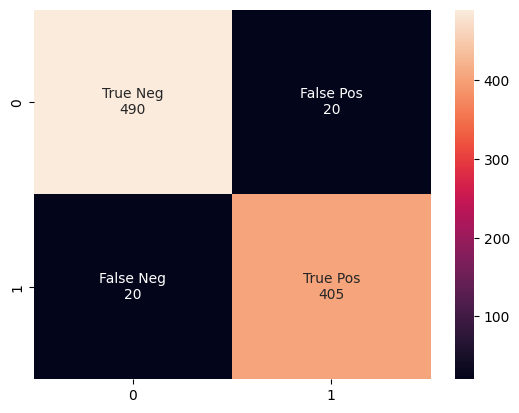

In [17]:
conf_mat=confusion_matrix(y_test_pred,Y_test)
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                conf_mat.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(conf_mat, annot=labels, fmt="")